In [8]:
import os
import shutil
from tensorflow.keras.applications import EfficientNetV2B1
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, models, regularizers
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data_dir = "./data"
train_dir = "./train_dir"
test_dir = "./test_dir"

categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes',
              'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

In [ ]:
for category in categories:
    category_path = os.path.join(data_dir, category)
    images = os.listdir(category_path)
    
    train_images, test_images = train_test_split(images, test_size=0.2)
    
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)
    
    for image in train_images:
        src = os.path.join(category_path, image)
        dest = os.path.join(train_dir, category, image)
        shutil.copyfile(src, dest)
        
    for image in test_images:
        src = os.path.join(category_path, image)
        dest = os.path.join(test_dir, category, image)
        shutil.copyfile(src, dest)

In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=categories,
    color_mode='rgb',
    batch_size=64,
    image_size=(224, 224),
    shuffle=True,
    seed=99,
)

Found 13456 files belonging to 12 classes.


In [5]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=categories,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=99,
)

Found 3649 files belonging to 12 classes.


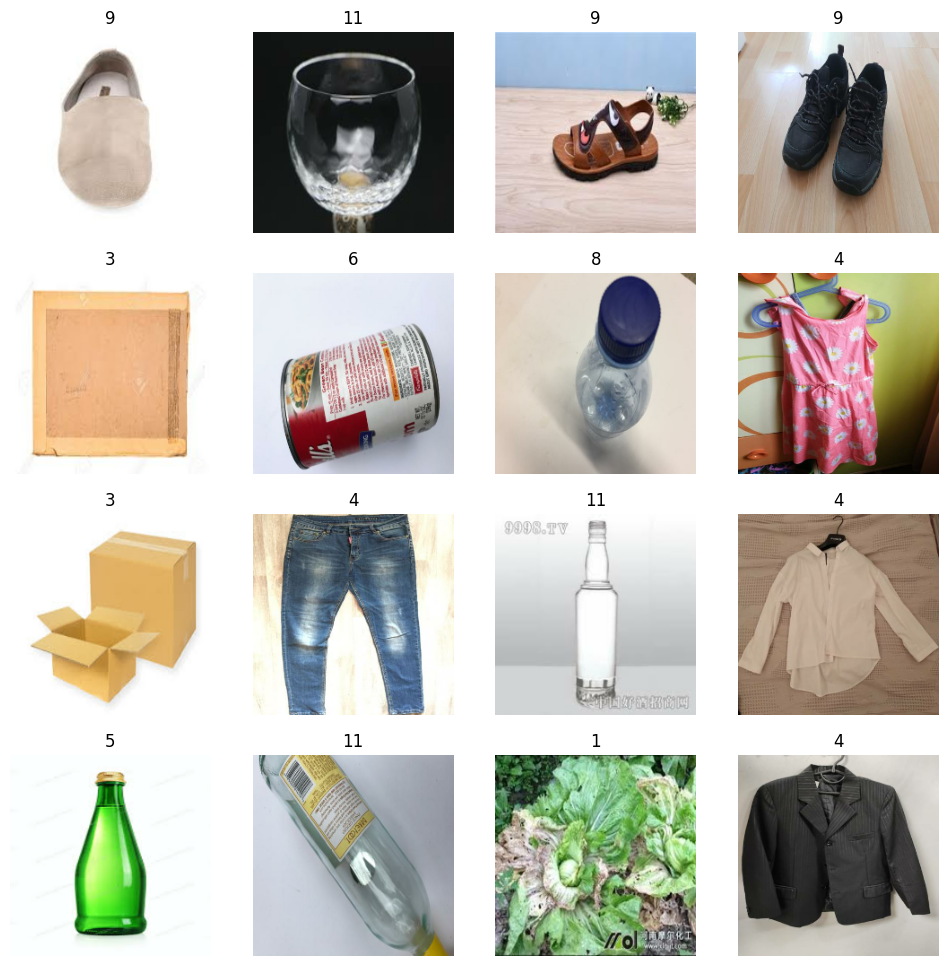

In [6]:
plt.figure(figsize=(12, 12))
for imgs, labels in train_dataset.take(2):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(imgs[i]/255)
        plt.title(np.argmax(labels[i], axis=0))
        plt.axis('off')

In [9]:
input_shape = (224,224,3)

model = models.Sequential([
    EfficientNetV2B1(weights='imagenet', include_top=False, input_shape=input_shape),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.08),
    layers.Dense(12, activation='softmax')
])

28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
pretrained = model.layers[0]
for layer in pretrained.layers[:-4]:
    layer.trainabel = False

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
checkpoint=ModelCheckpoint(r'./models/model2.keras',
                          monitor='val_accuracy',
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor='val_accuracy',
                        mode='max',
                       min_delta=0.001,
                       patience=20,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b1 (Functional)  │ (None, 7, 7, 1280)     │     6,931,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,014,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,946,304 (41.76 MB)

 Trainable params: 10,875,104 (41.49 MB)

 Non-trainable params: 71,200 (278.12 KB)

In [ ]:
history = model.fit(
    train_dataset, 
    validation_data=test_dataset,
    epochs=50,
    callbacks=callbacks)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()